# ELO: V2

Let's make a couple improvements to ELO:
1. MOV Awareness: large wins give more ELO points than small wins.
2. Inter Season regression to the mean: Retain 3/4 of your rating, and 1/4 is 1500 --> the mean.

In [77]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import pendulum
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
import utils

In [78]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

Text(0.5, 1.0, 'After 2014-15')

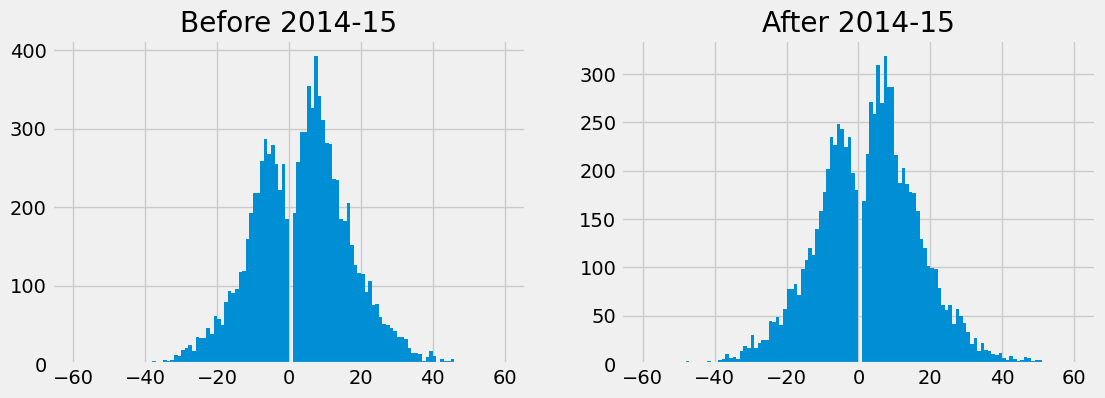

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

cutoff = '2014-15'

(
    df
    .query('home_away == "Home"')
    .query(f'season <= "{cutoff}"')
    .mov
    .hist(
        bins=np.arange(-60,61,1),
        ax=ax1
    )
)

(
    df
    .query('home_away == "Home"')
    .query(f'season > "{cutoff}"')
    .mov
    .hist(
        bins=np.arange(-60,61,1),
        ax=ax2
    )
)

ax1.set_title(f'Before {cutoff}')
ax2.set_title(f'After {cutoff}')

In [80]:
summary = (
    df
    .query('home_away == "Home"')
    .groupby('season')
    .agg(
        HomeFieldAdvantage=('mov', 'mean'),
        Variance = ('mov', 'std')
    )
    .reset_index()
)

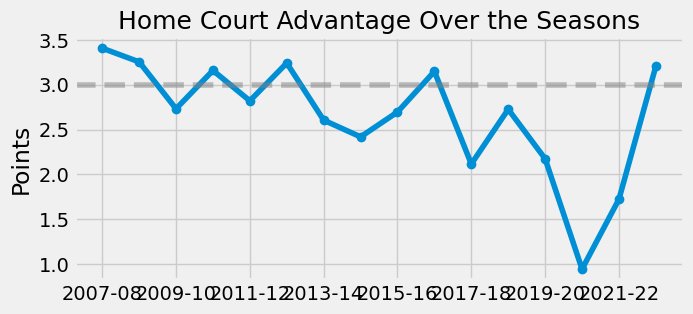

In [81]:
(
    summary
    .plot(
        x='season', 
        y='HomeFieldAdvantage', 
        marker='o',
        figsize=(7,3),
        legend=False
    )
)

plt.title('Home Court Advantage Over the Seasons', size=18)
plt.xlabel('')
plt.ylabel('Points')
plt.axhline(
    y=3,
    ls='--',
    color='grey',
    alpha=0.5
)

plt.show()

## Some Sims

In [82]:
def get_mov_multiplier(mov, elo_diff):
    numerator = (mov + 3) ** 0.8
    denominator = (7.5 + 0.006 * elo_diff)
    
    mov_multiplier = numerator / denominator
    
    return mov_multiplier

In [83]:
(3 - 10) ** 2

49

In [84]:
elo_diffs = np.arange(-250,300,50)
movs = np.arange(1, 21, 1)

rows=[]

for elo_diff in elo_diffs:
    for mov in movs:
        row = {
            'elo_diff': elo_diff,
            'mov': mov,
            'mov_multiplier': get_mov_multiplier(mov, elo_diff),
        }
        rows.append(row)

OK, we learned that this only works as an adjustment for the winning team. So, you find mov, then, you make that positive, then, based on the sign of home_favoritenss, you make elo_diff either positive or negative.

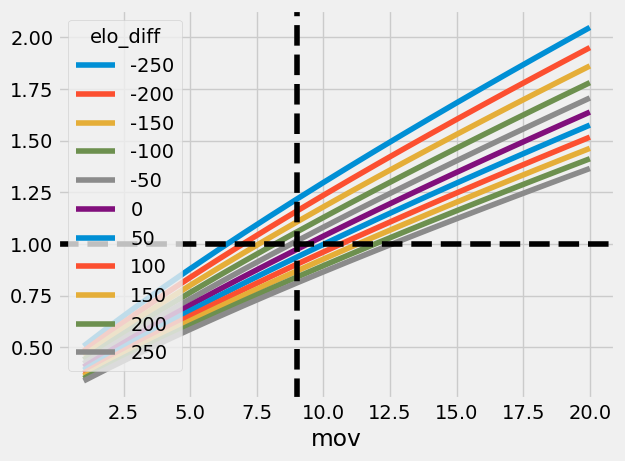

In [85]:
fig, ax = plt.subplots(1,1)

(
    pd.DataFrame(rows)
    .pivot_table(
        index='mov',
        columns='elo_diff',
        values='mov_multiplier'
    )
    .plot(
        ax=ax
    )
)

ax.axhline(
    y=1,
    ls='--',
    color='black'
)

ax.axvline(
    x=9,
    ls='--',
    color='black'
)

In [86]:
(
    pd.DataFrame(rows)
    .pivot_table(
        index='mov',
        columns='elo_diff',
        values='mov_multiplier'
    )
)

elo_diff,-250,-200,-150,-100,-50,0,50,100,150,200,250
mov,,,,,,,,,,,
1,0.505239,0.481180,0.459308,0.439338,0.421032,0.404191,0.388645,0.374251,0.360885,0.348441,0.336826
2,0.603983,0.575222,0.549076,0.525203,0.503319,0.483186,0.464602,0.447395,0.431416,0.416540,0.402655
3,0.698827,0.665550,0.635297,0.607676,0.582356,0.559062,0.537559,0.517650,0.499162,0.481950,0.465885
4,0.790546,0.752901,0.718678,0.687431,0.658788,0.632437,0.608112,0.585590,0.564676,0.545204,0.527031
5,0.879672,0.837783,0.799702,0.764932,0.733060,0.703738,0.676671,0.651609,0.628337,0.606670,0.586448
6,0.966591,0.920563,0.878719,0.840514,0.805493,0.773273,0.743532,0.715993,0.690422,0.666614,0.644394
7,1.051596,1.001520,0.955996,0.914431,0.876330,0.841276,0.808920,0.778960,0.751140,0.725238,0.701064
8,1.134914,1.080870,1.031740,0.986882,0.945762,0.907931,0.873011,0.840677,0.810653,0.782699,0.756609
9,1.216729,1.158789,1.106117,1.058025,1.013941,0.973383,0.935945,0.901281,0.869092,0.839123,0.811152


<AxesSubplot: >

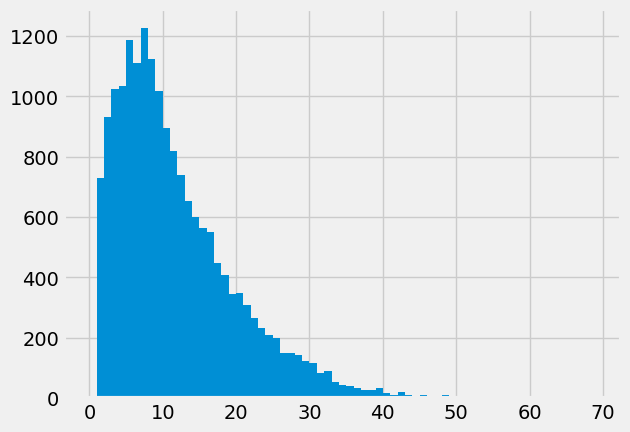

In [87]:
(
    df
    .query('mov > 0')
    .mov
    .hist(
        bins=np.arange(0,70,1)
    )
)

In [88]:
(
    df
    .query('mov > 0')
    .assign(
        dummy='dummy'
    )
    .groupby('dummy')
    .agg(
        Mean = ('mov', 'mean'),
        Median = ('mov', 'median'),
        StdDev = ('mov', 'std'),
    )
)

,Mean,Median,StdDev
dummy,,,
dummy,11.288445,9.0,8.216622


OK, so, this is the average MOV of the winning team, so, is that how they got their parameters for the MOV Aware ELO ratings??? Interewsting. 9 points is the threshold where the winning team starts getting an MOV Bump.

We should have some charts showing how some MOV champions ELO ratings looked vs some MOV Frauds. We can start with bucks and knicks for a few seasons. 

We can also rank by MOV
We can also rank by biggest delta in MOV to regular ELO

I anticipate these will start wide earlier in the season and then they get smaller later in the seasons.

In [89]:
class EloMOV:
    def __init__(self, dt, game_id, home, away, home_mov, home_elo=None, away_elo=None,point_spread=None,homefield=100,k=22, mov_multiplier=None):
        self.game_id = game_id
        self.dt = dt
        self.home = home
        self.away = away
        self.home_mov = home_mov
        self.point_spread = point_spread
        
        self.home_elo = home_elo
        self.away_elo = away_elo
        
        self.elo_diff = None
        
        self.homefield = homefield
        self.k = k
    
    def _get_q(self, elo):
        q = 10 ** (elo / 400)
        
        return q
    
    def get_home_expectation(self):
        home_elo = self.home_elo + self.homefield
        
        expectation = (
            self._get_q(home_elo) / (self._get_q(self.away_elo) + self._get_q(home_elo))
        )
        
        return expectation
    
    def get_mov_multiplier(self):
        '''
        Update Elo points based on MOV. 
        Median MOV of winning teams is 9 pts, so, we want to give more credit to a team that wins by 15 than to a team that wins by 5.
        '''
        
        if (np.sign(self.home_mov) == np.sign(self.elo_diff)):
            # Better team wins
            sign = 1
        else:
            # Worse Team wins
            sign = -1
                           
                           
        numerator = (abs(self.home_mov) + 3) ** 0.8
        denominator = (7.5 + sign * 0.006 * abs(self.elo_diff))

        mov_multiplier = numerator / denominator
        
        return mov_multiplier
    
    def UpdateElo(self):
        self.elo_diff = self.home_elo - self.away_elo + self.homefield
        
        if self.get_home_expectation() >= 0.5 and self.home_mov > 0:
            # better team wins
            self.mov_multiplier = self.get_mov_multiplier()
            
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation()) * self.mov_multiplier
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation()) * self.mov_multiplier
        
        elif self.get_home_expectation() >= 0.5 and self.home_mov < 0:
            ## Worse team wins
            self.mov_multiplier = self.get_mov_multiplier()
            
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation()) * self.mov_multiplier
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation()) * self.mov_multiplier
        
        elif self.get_home_expectation() < 0.5 and self.home_mov < 0:
            ## better team_wins
            self.mov_multiplier = self.get_mov_multiplier()
            
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation()) * self.mov_multiplier
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation()) * self.mov_multiplier
        
        elif self.get_home_expectation() < 0.5 and self.home_mov > 0:
            ## Worse team wins
            self.mov_multiplier = self.get_mov_multiplier()
            
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation()) * self.mov_multiplier
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation()) * self.mov_multiplier
            
def clean_br_date(input_string):
    day_of_week, raw_month, raw_date, raw_year = input_string.split(' ')
    if raw_month == 'Dec':
        month = 12
    elif raw_month == 'Jan':
        month = 1
    elif raw_month == 'Feb':
        month = 2
    elif raw_month == 'Mar':
        month = 3
    elif raw_month == 'Apr':
        month = 4
    elif raw_month == 'May':
        month = 5
        
    year = int(raw_year)
    day = int(raw_date)
    
    return pendulum.Date(year, month, day)

def get_elo(team, elos):
    elo = (
        elos
        .query(f'team == "{team}"')
        .sort_values(by='dt', ascending=False)
        .elo
        .tolist()
        [0]
    )
    
    return elo

In [90]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

games = (
    df
    .query('game_number <= 82')
    .query('season >= "2008-09"')
    .query('home_away == "Home"')
    [['game_id', 'season', 'dt', 'team', 'opponent', 'mov', 'point_spread', 'game_number']]
    .rename(
        columns={
            'team': 'home',
            'opponent': 'away',
            'mov': 'home_mov'
        }
    )
    .sort_values(
        by=['season', 'dt', 'home']
    )
    .assign(
        dt = lambda x: x['dt'].apply(utils.clean_date)
    )
)

games.tail(10)

,game_id,season,dt,home,away,home_mov,point_spread,game_number
36017,ea48985bdcb918f19a9a443bd9e2cdd3,2022-23,2022-12-10,Miami,SanAntonio,-4,-12.0,27.0
36283,dc6dec95fe5845c04a5ee941b9114ea2,2022-23,2022-12-10,Portland,Minnesota,6,-5.5,26.0
36417,ea252a4d92c55b786f23138cb671412d,2022-23,2022-12-10,Washington,LAClippers,-7,5.0,27.0
35642,bbb7141a0ef6c522272d91108bbca97d,2022-23,2022-12-11,Atlanta,Chicago,1,-3.5,27.0
35830,47b2efcef107631e33fb88415265d618,2022-23,2022-12-11,Detroit,LALakers,-7,5.0,29.0
35883,2821a94f38d661ae7edfa86e8a50325b,2022-23,2022-12-11,Houston,Milwaukee,5,10.0,26.0
36123,879e6ade0daa4d622ed9ccc61477f1c6,2022-23,2022-12-11,NewOrleans,Phoenix,5,-3.5,26.0
36150,1d6f3ae7deea41c203d3e71544206b05,2022-23,2022-12-11,NewYork,Sacramento,13,-2.5,27.0
36204,380ac405ac1f057627885807fe70ecf2,2022-23,2022-12-11,Orlando,Toronto,12,6.5,28.0
36230,0b03297c101c3e8cfd5eaaf0b3f5ef4d,2022-23,2022-12-11,Philadelphia,Charlotte,18,-10.5,26.0


In [91]:
teams = games.home.unique().tolist()

elos = pd.DataFrame(
    {
        'team': teams,
        'elo': np.repeat(1500, len(teams)),
        'dt': np.repeat(pendulum.Date(2007,10,31), len(teams))
    }
)

elos.tail()

,team,elo,dt
25,Indiana,1500,2007-10-31
26,Milwaukee,1500,2007-10-31
27,Nets,1500,2007-10-31
28,NewOrleans,1500,2007-10-31
29,Sacramento,1500,2007-10-31


In [92]:
rows = []

for raw in games.to_dict('records'):
    game = EloMOV(home=raw['home'], away=raw['away'], dt=raw['dt'], home_mov=raw['home_mov'], point_spread=raw['point_spread'], game_id=raw['game_id'])
    game.home_elo = get_elo(game.home, elos)
    game.away_elo = get_elo(game.away, elos)

    # Pre-game info
    
    row = {
        'game_id': game.game_id,
        'home': game.home,
        'away': game.away,
        'home_elo': game.home_elo,
        'away_elo': game.away_elo,
        'home_mov': game.home_mov,
        'point_spread': game.point_spread,
        'dt': game.dt,
    }
   
    game.UpdateElo()
    home_update = {
        'team': game.home,
        'elo': game.home_elo,
        'dt': game.dt
    }
    
    elos = elos.append(home_update, ignore_index=True)

    away_update = {
        'team': game.away,
        'elo': game.away_elo,
        'dt': game.dt
    }
    
    
    # Write to database: Elos
    elos = elos.append(away_update, ignore_index=True)
    
    # Write to database: Pre and Post Game elos, plus game result and point spread.
    post_game_update = {
        'home_elo__post': game.home_elo,
        'away_elo__post': game.away_elo,
    }

    row.update(post_game_update)
    
    rows.append(row)

## Review

In [93]:
dates = elos.dt.unique().tolist()

final = (
    pd.DataFrame({'dt': dates})
    .merge(
        pd.DataFrame({'team': teams}),
        how='cross'
    )
    .assign(
        dummy='dummy'
    )
    .merge(
        elos,
        on=['dt', 'team'],
        how='left'
    )
    .assign(
        elo = lambda x: x.groupby('team')['elo'].transform(lambda s: s.ffill())
    )
    .merge(
        (
            games
            [['season', 'dt']]
            .drop_duplicates()
        ),
        on='dt',
        how='left'
    )
)

final.tail()

,dt,team,dummy,elo,season
67526,2022-12-11,Indiana,dummy,1404.977950,2022-23
67527,2022-12-11,Milwaukee,dummy,1559.507710,2022-23
67528,2022-12-11,Nets,dummy,1522.983625,2022-23
67529,2022-12-11,NewOrleans,dummy,1593.429344,2022-23
67530,2022-12-11,Sacramento,dummy,1488.659541,2022-23


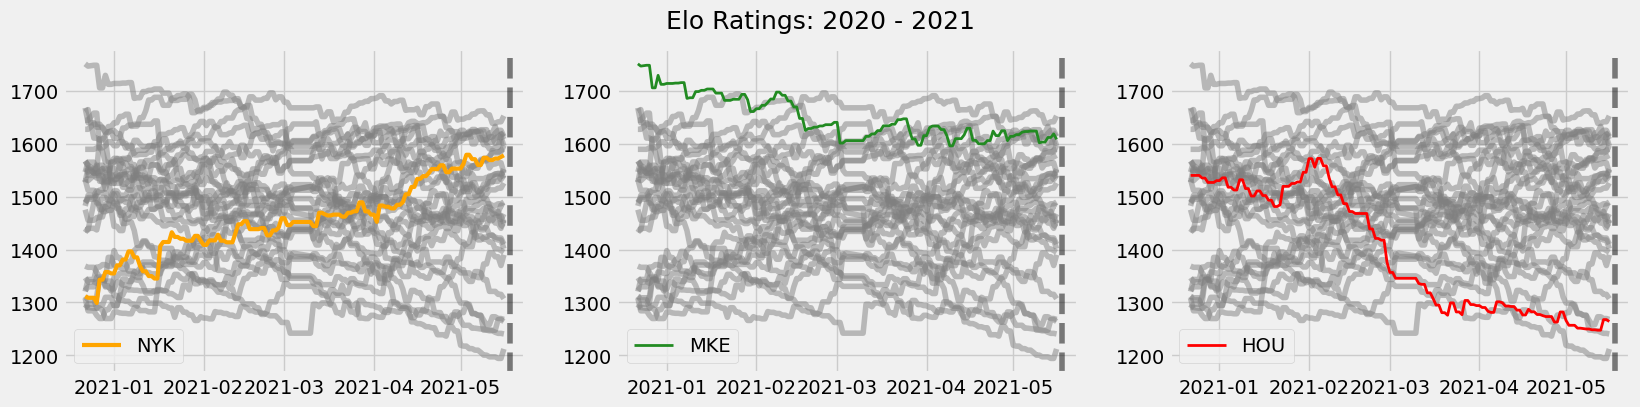

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

team = 'NewYork'

(
    final
    .query(f'team != "{team}"')
    .query('season == "2020-21"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax1
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='Orange',
        ax=ax1,
        label='NYK',
        lw=3
    )
)

team = 'Milwaukee'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax2
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='forestgreen',
        ax=ax2,
        label='MKE',
        lw=2
    )
)

ax1.set_xlabel('')
ax2.set_xlabel('')

team = 'Houston'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax3
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='red',
        ax=ax3,
        label='HOU',
        lw=2
    )
)

ax1.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax2.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax3.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.suptitle('Elo Ratings: 2020 - 2021', size=18)
plt.show()

In [95]:
home_field_advantage = 100

scoreboard = (
    pd.DataFrame(rows)
    .assign(
        elo_diff = lambda x: x['home_elo'] - x['away_elo'] + home_field_advantage,
        winner = lambda x: x['home_mov'].transform(lambda s: 'Away' if s < 0 else 'Home'),
        
        vegas_prediction = lambda x: x['point_spread'].transform(lambda s: 'Home' if s < 0 else 'Away'),
        elo_prediction = lambda x: x['elo_diff'].transform(lambda s: 'Away' if s < 0 else 'Home'),
        
        vegas_correct = lambda x: x['winner'] == x['vegas_prediction'],
        elo_correct = lambda x: x['winner'] == x['elo_prediction']
        
    )
    .merge(
        (
            games
            [['season', 'game_id', 'game_number']]
            .drop_duplicates()
        ),
        on='game_id',
        how='left'
    )
)

scoreboard.tail(20)

,game_id,home,away,home_elo,away_elo,home_mov,point_spread,dt,home_elo__post,away_elo__post,elo_diff,winner,vegas_prediction,elo_prediction,vegas_correct,elo_correct,season,game_number
16919,d4d081054ab119583e3dc4862a102ef3,Nets,Atlanta,1512.832024,1493.163753,4,-7.0,2022-12-09,1517.076771,1488.987771,119.668271,Home,Home,Home,True,True,2022-23,27.0
16920,ac266b6ab35a4dbe33ea0bb5f27a43b3,NewOrleans,Phoenix,1579.518806,1597.511127,11,1.5,2022-12-09,1588.251338,1589.047324,82.007679,Home,Away,Home,False,True,2022-23,25.0
16921,c1a0626042b6e6fd7b8bc8d38f192afc,Orlando,Toronto,1279.286857,1522.181211,4,8.5,2022-12-09,1290.201476,1511.478422,-142.894353,Home,Away,Away,False,False,2022-23,27.0
16922,daec343d40932439249d1183ac4eba94,Philadelphia,LALakers,1537.250641,1427.744660,11,-5.0,2022-12-09,1542.031039,1423.064749,209.505981,Home,Home,Home,True,True,2022-23,25.0
16923,e6730803068407a5154632c40c31c856,Utah,Minnesota,1514.040684,1471.725777,-10,0.0,2022-12-09,1496.158732,1489.033645,142.314907,Away,Away,Home,True,False,2022-23,28.0
16924,5054b09e0b0fd3f82134bbbdcd14ae05,Chicago,Dallas,1462.796404,1555.711814,29,-5.0,2022-12-10,1485.655070,1534.383479,7.084590,Home,Home,Home,True,True,2022-23,25.0
16925,3483d8c7f45d20aa4f8ef2b1136595ec,Cleveland,OklahomaCity,1525.896311,1384.569601,8,-4.5,2022-12-10,1529.237008,1381.280032,241.326710,Home,Home,Home,True,True,2022-23,27.0
16926,568cdce3b618ce074b46e10b0aa224c7,Denver,Utah,1523.022704,1496.158732,5,-11.5,2022-12-10,1527.592655,1491.669538,126.863972,Home,Home,Home,True,True,2022-23,26.0
16927,261b37a776c6022e07d21dea6540622e,GoldenState,Boston,1536.461780,1730.699406,16,2.5,2022-12-10,1557.615630,1710.506809,-94.237627,Home,Away,Away,False,False,2022-23,27.0
16928,4541d8a27f86846e408fc7238f8e6374,Indiana,Nets,1410.990639,1517.076771,-3,-8.5,2022-12-10,1404.977950,1522.983625,-6.086133,Away,Home,Away,False,True,2022-23,27.0


In [96]:
vegas_confusion = (
    scoreboard
    .groupby(['winner', 'vegas_prediction'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .pivot_table(
        index='vegas_prediction',
        columns='winner',
        values='games'
    )
)

display(Markdown('### Vegas Confusion Matrix'))
display(vegas_confusion)

elo_confusion = (
    scoreboard
    .groupby(['winner', 'elo_prediction'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .pivot_table(
        index='elo_prediction',
        columns='winner',
        values='games'
    )
)

display(Markdown('### Elo Confusion Matrix'))
display(elo_confusion)

### Vegas Confusion Matrix

winner,Away,Home
vegas_prediction,,
Away,3817,2081
Home,3240,7801


### Elo Confusion Matrix

winner,Away,Home
elo_prediction,,
Away,3076,1716
Home,3981,8166


In [97]:
batting_average__vegas = (
    scoreboard
    .groupby(['season', 'game_number', 'vegas_correct'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['season', 'vegas_correct'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['season', 'game_number'],
        columns='vegas_correct',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['season', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        ## Calculate Vegas batting average:
        Vegas = lambda x: 100 * x['correct'] / x['total']

    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['season', 'game_number', 'Vegas']]
)

batting_average__elo = (
    scoreboard
    .groupby(['season', 'game_number', 'elo_correct'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['season', 'elo_correct'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['season', 'game_number'],
        columns='elo_correct',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['season', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        ## Calculate Elo batting average:
        EloMOV = lambda x: 100 * x['correct'] / x['total']

    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['season', 'game_number', 'EloMOV']]
)

batting_averages = (
    batting_average__elo
    .merge(
        batting_average__vegas
    )
    .melt(
        id_vars=['season', 'game_number'],
        var_name='Predictor',
        value_name='Batting Average'
    )
)

In [98]:
batting_averages

,season,game_number,Predictor,Batting Average
0,2008-09,20.0,EloMOV,62.000000
1,2008-09,21.0,EloMOV,63.091483
2,2008-09,22.0,EloMOV,63.333333
3,2008-09,23.0,EloMOV,63.188406
4,2008-09,24.0,EloMOV,62.500000
...,...,...,...,...
1727,2022-23,25.0,Vegas,66.133333
1728,2022-23,26.0,Vegas,66.237113
1729,2022-23,27.0,Vegas,66.080402
1730,2022-23,28.0,Vegas,66.000000


In [99]:
elo_v1 = pd.read_csv('../data/Elo Batting Averages.csv')

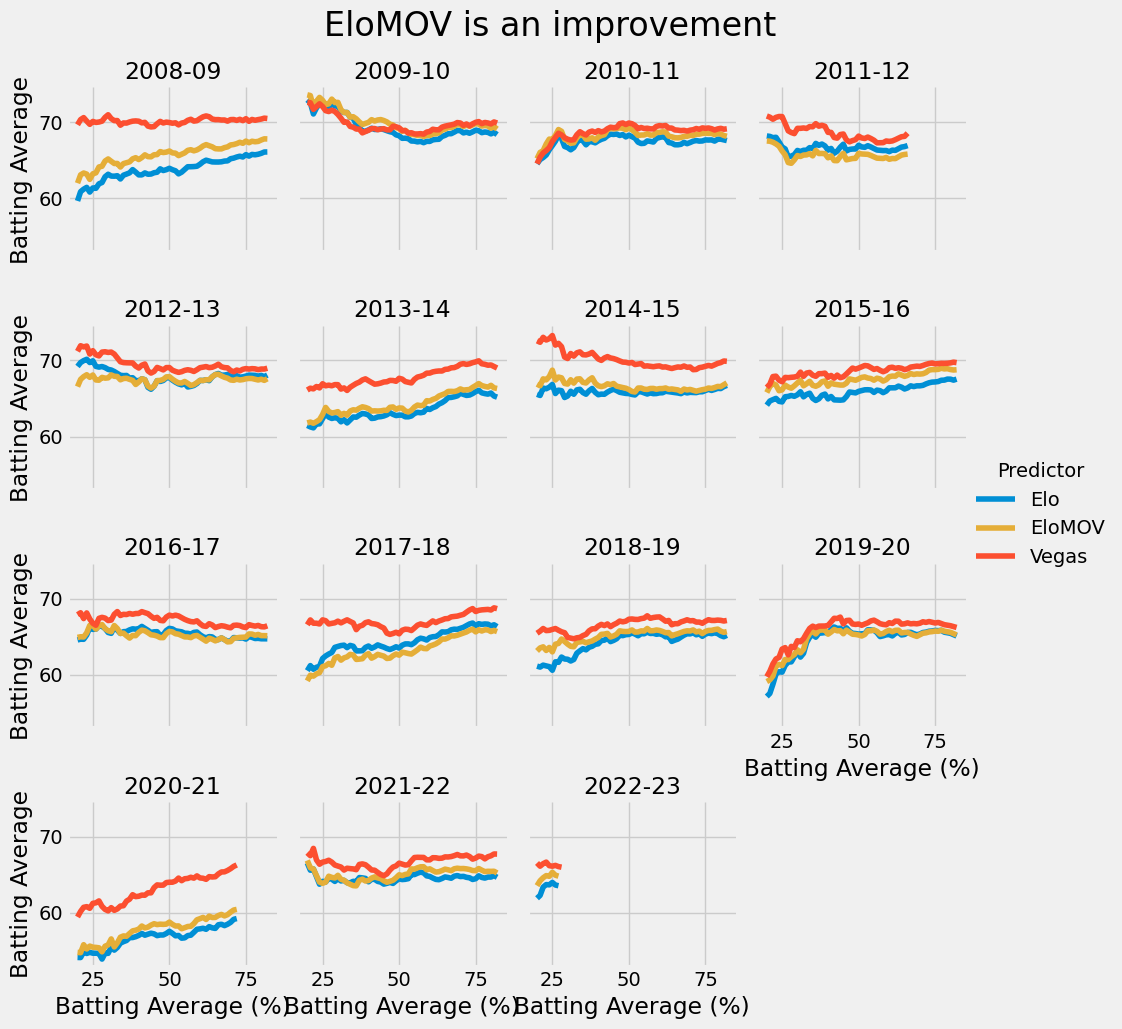

In [100]:
style.use('fivethirtyeight')

g = sns.relplot(
    data=pd.concat([elo_v1, batting_averages]).reset_index(),
    x='game_number',
    y='Batting Average',
    hue='Predictor',
    col='season',
    col_wrap=4,
    kind='line',
    height=2.5,
    aspect=1,
    palette=['#008fd5', '#e5ae38', '#fc4f30', ]
)

g.set_axis_labels("Batting Average (%)")
g.set_titles(col_template="{col_name}")

g.fig.suptitle('EloMOV is an improvement', y=1.03, size=24)

plt.show()

In [101]:
(
    pd.concat([elo_v1, batting_averages])
    .query('game_number == 82')
    .pivot_table(
        index='season', 
        columns='Predictor', 
        values='Batting Average'
    )
    .round(1)
)

Predictor,Elo,EloMOV,Vegas
season,,,
2008-09,66.1,67.8,70.5
2009-10,68.4,69.1,69.9
2010-11,67.6,68.2,69.1
2012-13,68.1,67.6,69.0
2013-14,65.2,66.3,69.0
2014-15,66.7,67.0,69.9
2015-16,67.5,68.8,69.7
2016-17,64.7,65.1,66.4
2017-18,66.3,65.7,68.7


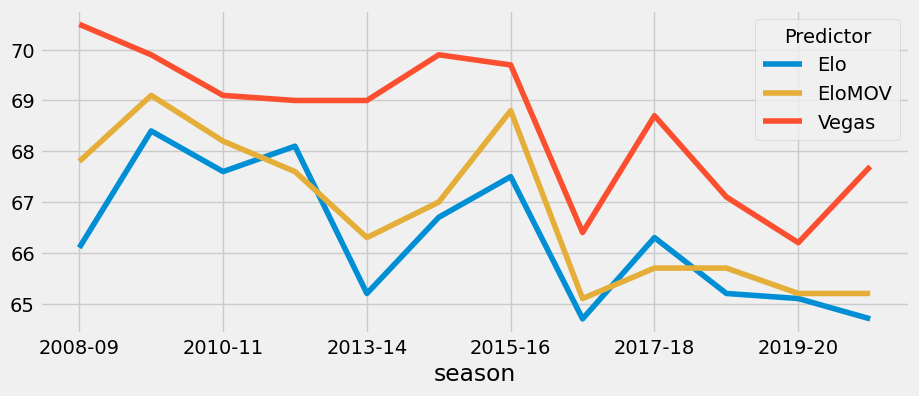

In [102]:
(
    pd.concat([elo_v1, batting_averages])
    .query('game_number == 82')
    .pivot_table(
        index='season', 
        columns='Predictor', 
        values='Batting Average'
    )
    .round(1)
    .plot(
        color=['#008fd5', '#e5ae38', '#fc4f30'],
        figsize=(10,4)
    )
)

plt.show()

## What About the Details?

- Where does EloMOV underperform Elo, and why?
- Team by team looks

In [103]:
(
    scoreboard
    .query('season == "2017-18"')
    .groupby('home')
    .agg(
        elo_correct = ('elo_correct', 'mean'),
        vegas_correct = ('vegas_correct', 'mean')
    )
    .reset_index()
    .assign(
        elo_losers = lambda x: x['vegas_correct'] - x['elo_correct']
    )
    .sort_values(by='elo_losers', ascending=False)
)

,home,elo_correct,vegas_correct,elo_losers
5,Dallas,0.390244,0.560976,0.170732
19,NewYork,0.536585,0.658537,0.121951
17,Nets,0.560976,0.682927,0.121951
22,Philadelphia,0.700000,0.800000,0.100000
0,Atlanta,0.585366,0.682927,0.097561
10,Indiana,0.682927,0.780488,0.097561
18,NewOrleans,0.634146,0.707317,0.073171
11,LAClippers,0.560976,0.634146,0.073171
8,GoldenState,0.707317,0.756098,0.048780
16,Minnesota,0.707317,0.756098,0.048780


In [104]:
(
    scoreboard
    .query('season == "2017-18"')
    .groupby('away')
    .agg(
        elo_correct = ('elo_correct', 'mean'),
        vegas_correct = ('vegas_correct', 'mean')
    )
    .reset_index()
    .assign(
        elo_losers = lambda x: x['vegas_correct'] - x['elo_correct']
    )
    .sort_values(by='elo_losers', ascending=False)
)

,away,elo_correct,vegas_correct,elo_losers
28,Utah,0.536585,0.756098,0.219512
24,Portland,0.487805,0.658537,0.170732
1,Boston,0.575000,0.725000,0.150000
18,NewOrleans,0.536585,0.682927,0.146341
16,Minnesota,0.585366,0.707317,0.121951
11,LAClippers,0.682927,0.756098,0.073171
14,Miami,0.536585,0.609756,0.073171
8,GoldenState,0.682927,0.756098,0.073171
29,Washington,0.487805,0.536585,0.048780
15,Milwaukee,0.658537,0.707317,0.048780


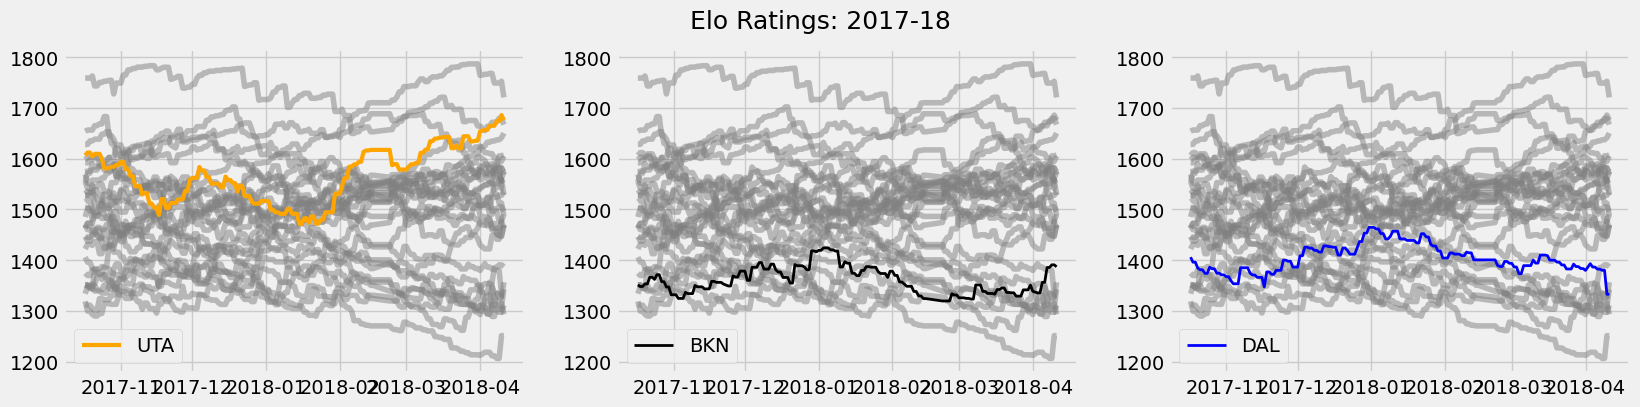

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

season = '2017-18'

team = 'Utah'

(
    final
    .query(f'team != "{team}"')
    .query(f'season == "{season}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax1
    )
)

(
    final
    .query(f'season == "{season}"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='Orange',
        ax=ax1,
        label='UTA',
        lw=3
    )
)

team = 'Nets'

(
    final
    .query(f'season == "{season}"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax2
    )
)

(
    final
    .query(f'season == "{season}"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='black',
        ax=ax2,
        label='BKN',
        lw=2
    )
)

ax1.set_xlabel('')
ax2.set_xlabel('')

team = 'Dallas'

(
    final
    .query(f'season == "{season}"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax3
    )
)

(
    final
    .query(f'season == "{season}"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='blue',
        ax=ax3,
        label='DAL',
        lw=2
    )
)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.suptitle(f'Elo Ratings: {season}', size=18)
plt.show()

This hasn't answered the question. I'm still not sure why elo so under-performed vegas this season.

Also, we should look at Elo vs EloMOV.

## ELO and Implied Lines

In [106]:
import statsmodels.api as sm

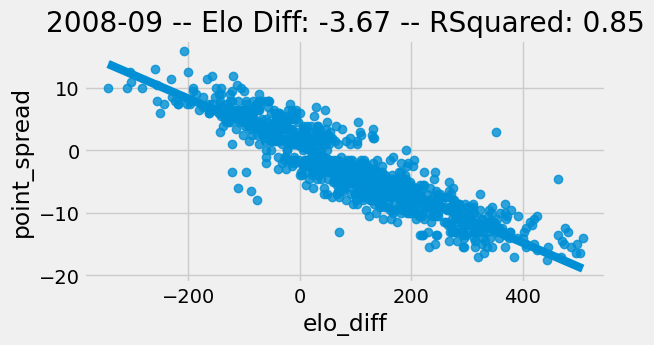

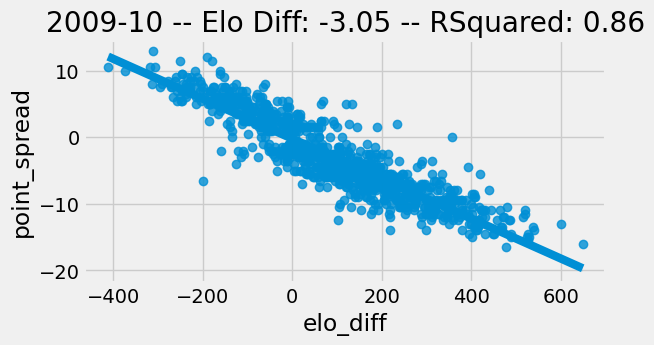

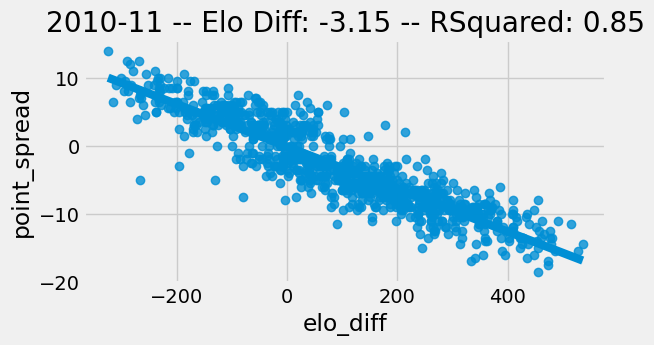

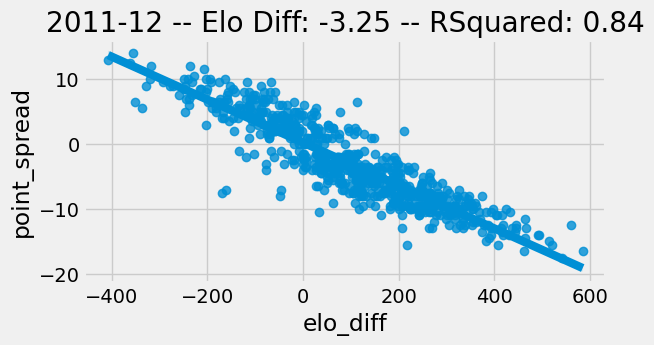

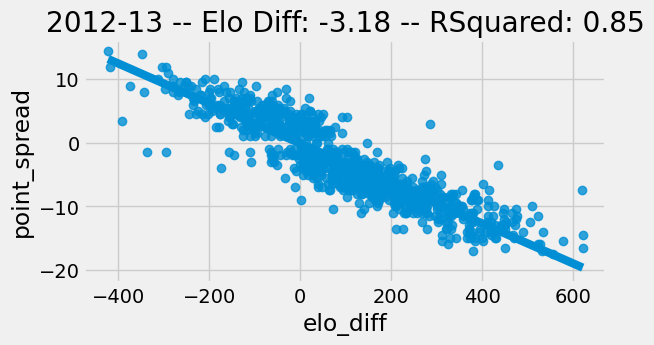

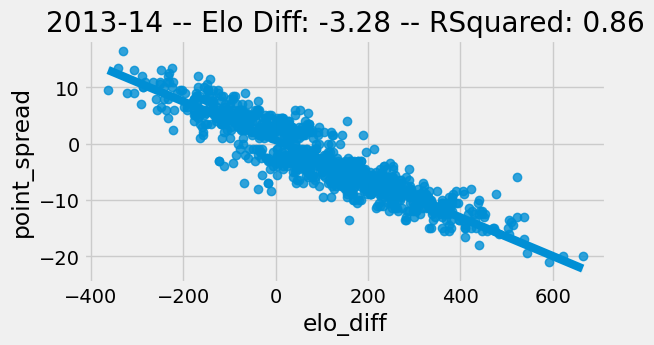

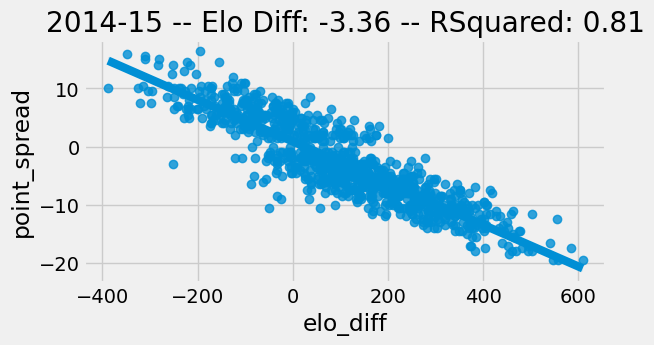

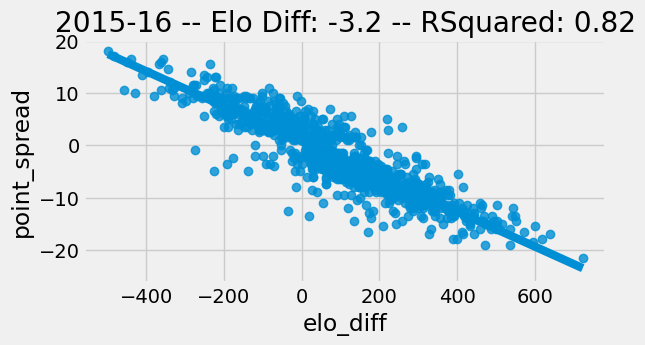

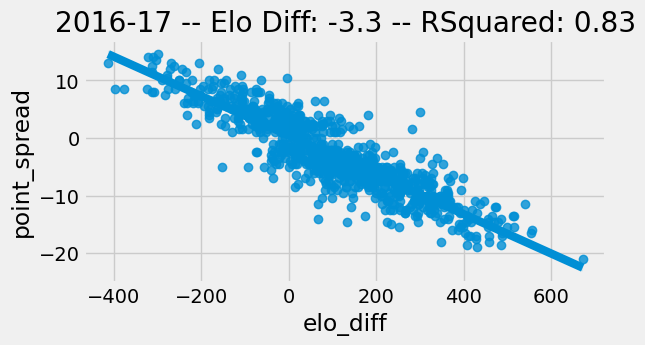

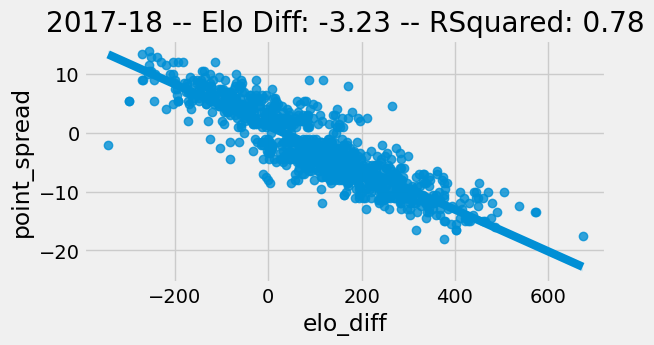

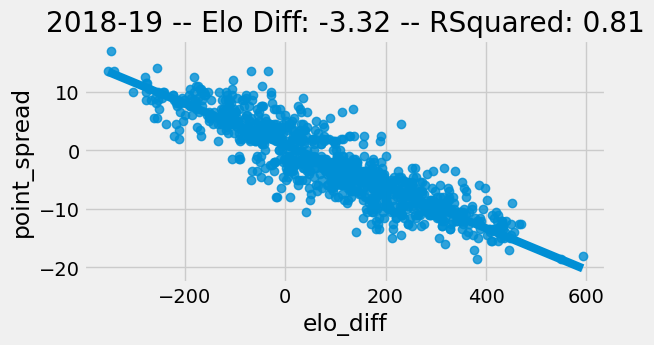

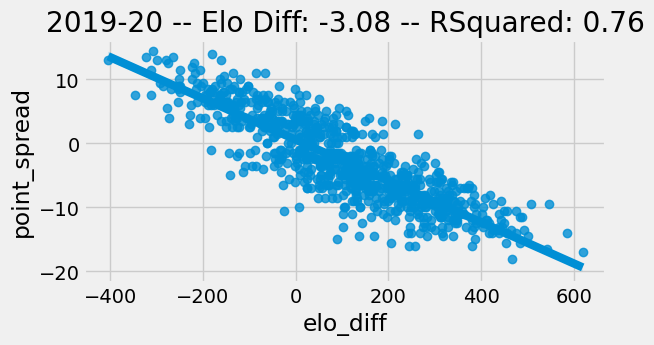

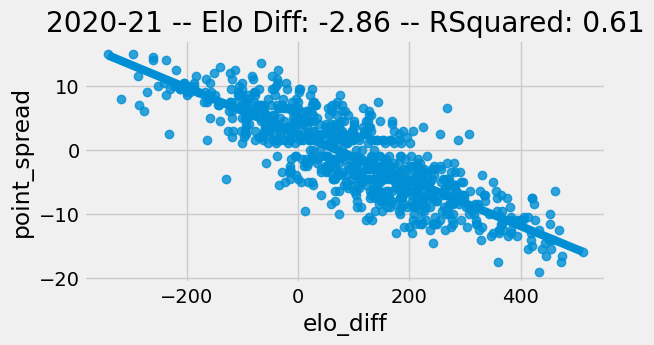

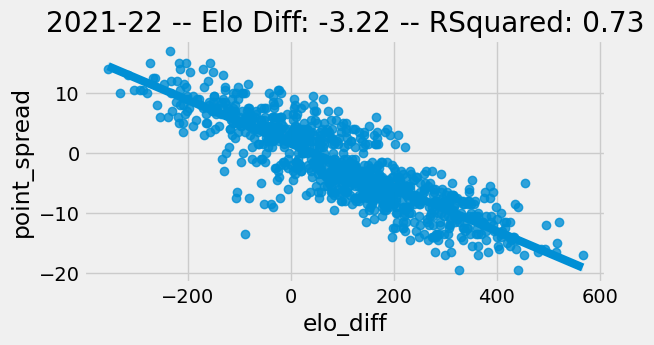

In [107]:
seasons = [
    season for season in scoreboard.season.unique().tolist()
    if season != '2022-23'
]

for season in seasons:
    model = sm.OLS(
        endog=scoreboard.query(f'season == "{season}"').query('game_number >= 20')['point_spread'],
        exog=scoreboard.query(f'season == "{season}"').query('game_number >= 20')['elo_diff']
    )

    elo_diff = float(round(model.fit().params * 100, 2))
    r_squared = float(round(model.fit().rsquared,2))

    fig, ax = plt.subplots(1,1, figsize=(6,3))

    sns.regplot(
        data = (
            scoreboard
            .query(f'season == "{season}"')
            .query('game_number >= 20')
        ),
        x='elo_diff',
        y='point_spread',
        ax=ax
    )

    ax.set_title(f'{season} -- Elo Diff: {elo_diff} -- RSquared: {r_squared}')

## Model Comparison with Base Elo

In [109]:
model_name = 'MOV Aware Elo'
seasons = scoreboard.season.unique().tolist()
response_variables = ['home_mov', 'point_spread']

model_results = []

for season in seasons:

    data = (
        scoreboard
        .query(f'season == "{season}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
    )
    
    for response_variable in response_variables:
    

        X = data['elo_diff']
        y =  data[response_variable]

        model = sm.OLS(y, X)
        results = model.fit()

        row = results.params.to_dict().copy()
        row['rsquared'] = results.rsquared
        row['season'] = season
        row['response_variable'] = response_variable

        row['model_name'] = model_name

        row['batting_average'] = data['elo_correct'].mean()

        model_results.append(row) 

In [111]:
base_elo = pd.read_csv('../data/Elo Results.csv')

In [120]:
total_results = (
    base_elo
    .query('response_variable == "home_mov"')
    .melt(
        id_vars=['season'],
        value_vars=['batting_average', 'rsquared'],
        var_name='feature_name',
        value_name='Base Elo'
    )
    .merge(
        (
            pd.DataFrame(model_results)
            .query('response_variable == "home_mov"')
            .melt(
                id_vars=['season'],
                value_vars=['batting_average', 'rsquared'],
                var_name='feature_name',
                value_name='MOV Aware Elo'
            )
        ),
        on=['season', 'feature_name'],
        how='left'
    )
)

total_results

,season,feature_name,Base Elo,MOV Aware Elo
0,2008-09,batting_average,0.681818,0.697674
1,2009-10,batting_average,0.668438,0.675877
2,2010-11,batting_average,0.684713,0.691083
3,2011-12,batting_average,0.669034,0.656250
4,2012-13,batting_average,0.676190,0.678307
5,2013-14,batting_average,0.664195,0.676907
6,2014-15,batting_average,0.670190,0.670190
7,2015-16,batting_average,0.692797,0.704449
8,2016-17,batting_average,0.646561,0.651852
9,2017-18,batting_average,0.683598,0.678307


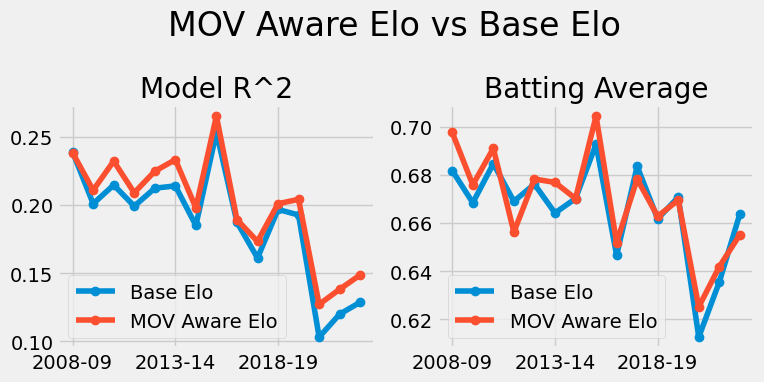

In [124]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

(
    total_results
    .query('feature_name == "rsquared"')
    .plot(
        x='season',
        y=['Base Elo', 'MOV Aware Elo'],
        ax=ax1,
        marker='o',
        legend=True,
        title='Model R^2'
    )
)

(
    total_results
    .query('feature_name == "batting_average"')
    .plot(
        x='season',
        y=['Base Elo', 'MOV Aware Elo'],
        ax=ax2,
        marker='o',
        legend=True,
        title='Batting Average'
    )
)

plt.suptitle('MOV Aware Elo vs Base Elo', y=1.2, size=24)

ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

In [126]:
(
    total_results
    .to_csv(
        '../data/Elo MOV Aware Results.csv',
        index=False
    )
)

In [127]:
total_results

,season,feature_name,Base Elo,MOV Aware Elo
0,2008-09,batting_average,0.681818,0.697674
1,2009-10,batting_average,0.668438,0.675877
2,2010-11,batting_average,0.684713,0.691083
3,2011-12,batting_average,0.669034,0.656250
4,2012-13,batting_average,0.676190,0.678307
5,2013-14,batting_average,0.664195,0.676907
6,2014-15,batting_average,0.670190,0.670190
7,2015-16,batting_average,0.692797,0.704449
8,2016-17,batting_average,0.646561,0.651852
9,2017-18,batting_average,0.683598,0.678307
